# Task-2

In [1]:
import sys
import os
sys.path.append(os.path.abspath('../scripts'))
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from data_processing import * 
from forecasting import *
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


## Load Data

In [3]:
df = load_close_data('tsla')

2025-03-04 22:21:36,513 - INFO - Loading tsla data...


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
2025-03-04 22:21:40,235 - INFO - Data loaded 


In [4]:
df.columns

Index(['Price'], dtype='object')

In [5]:
df.head()

,Price
Date,
2015-01-02,14.620667
2015-01-05,14.006000
2015-01-06,14.085333
2015-01-07,14.063333
2015-01-08,14.041333


In [6]:
# Resample to fill in missing dates
df_resampled = df.resample('D').ffill()  # Forward fill missing data

In [7]:
# Step 4: Verify frequency
print(df_resampled.index.freq)  # Should show the frequency, e.g., 'D' for daily

<Day>


In [9]:
df_resampled.head(10)

,Price
Date,
2015-01-02,14.620667
2015-01-03,14.620667
2015-01-04,14.620667
2015-01-05,14.006000
2015-01-06,14.085333
2015-01-07,14.063333
2015-01-08,14.041333
2015-01-09,13.777333
2015-01-10,13.777333


In [10]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_resampled['Price'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
result

ADF Statistic: -1.4158672607295455
p-value: 0.5746459596704767


(-1.4158672607295455,
 0.5746459596704767,
 25,
 3683,
 {'1%': -3.4321267753335545,
  '5%': -2.862325080792323,
  '10%': -2.5671879100443813},
 22755.939314865253)

- since p-value is more than 0.05 it shows the data is not stationary
- the ADF value is also greater than 1, 5, and 10% of critical values shows non stationarity of the data

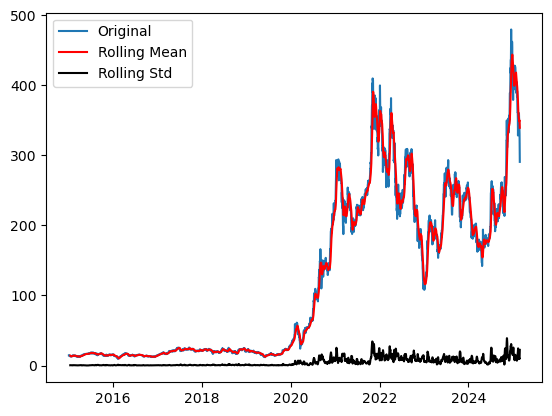

In [11]:
rolling_mean = df_resampled['Price'].rolling(window=12).mean()
rolling_std = df_resampled['Price'].rolling(window=12).std()

plt.plot(df_resampled['Price'], label='Original')
plt.plot(rolling_mean, label='Rolling Mean', color='red')
plt.plot(rolling_std, label='Rolling Std', color='black')
plt.legend()
plt.show()

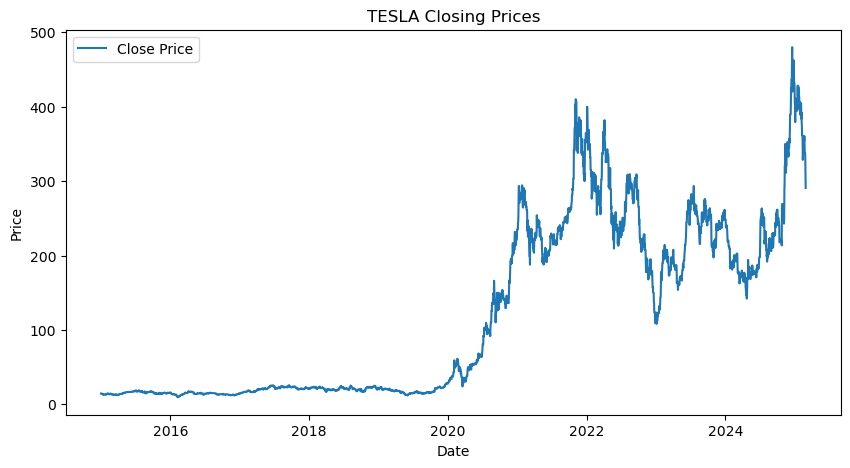

In [12]:
# Step 2: Visualize the Closing Prices
plt.figure(figsize=(10, 5))
plt.plot(df_resampled['Price'], label='Close Price')
plt.title(f'TESLA Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [13]:
df_resampled

,Price
Date,
2015-01-02,14.620667
2015-01-03,14.620667
2015-01-04,14.620667
2015-01-05,14.006000
2015-01-06,14.085333
...,...
2025-02-22,337.799988
2025-02-23,337.799988
2025-02-24,330.529999


In [14]:
df_resampled.isnull().sum()

Price    0
dtype: int64

In [15]:
# Resample to fill in missing dates
df_resampled = df.resample('D').ffill()  # Forward fill missing data

In [16]:
df_cleaned= df.copy()
df_cleaned['Close_Diff'] = df_cleaned['Price'].diff()
df_cleaned = df_cleaned.dropna()

ADF Statistic: -9.07148433131227
p-value: 4.290310351047208e-15
Critical Values: {'1%': -3.4329434877271816, '5%': -2.862685793891119, '10%': -2.567379949649765}


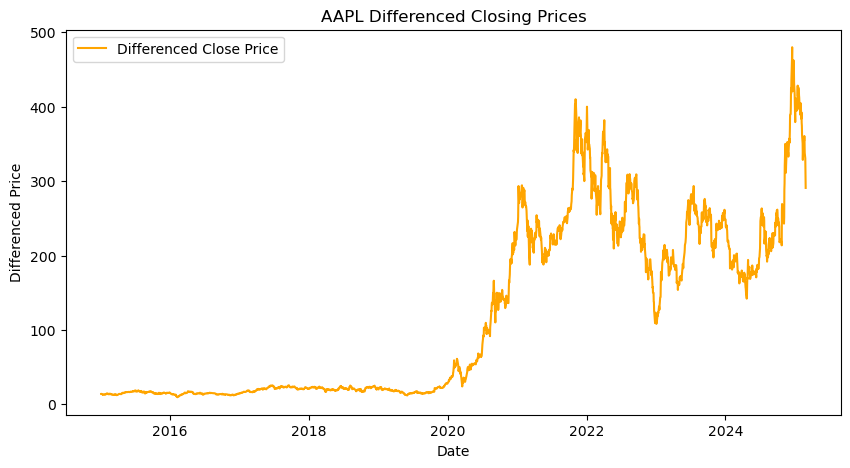

In [17]:

# Step 4: Check for Stationarity
result = adfuller(df_cleaned['Close_Diff'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

# Step 5: Visualize Differenced df_resampled
plt.figure(figsize=(10, 5))
plt.plot(df_cleaned['Price'], label='Differenced Close Price', color='orange')
plt.title(f'AAPL Differenced Closing Prices')
plt.xlabel('Date')
plt.ylabel('Differenced Price')
plt.legend()
plt.show()

### Split Data

In [18]:
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]


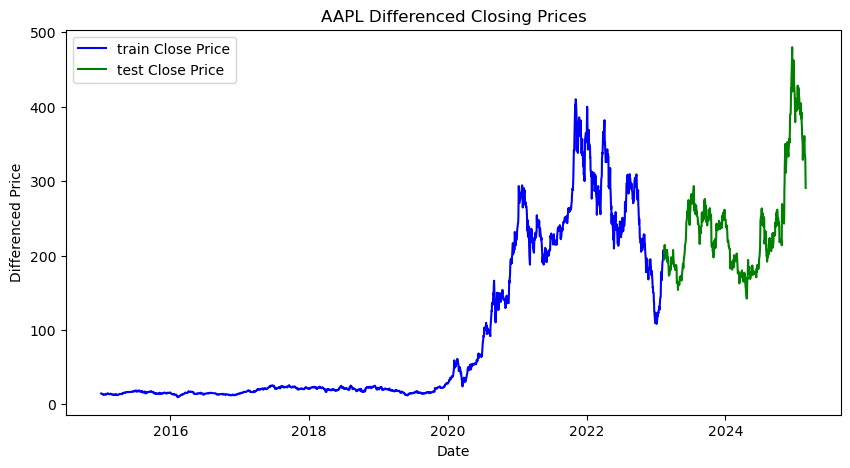

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(train['Price'], label='train Close Price', color='blue')
plt.plot(test['Price'], label='test Close Price', color='green')
plt.title(f'AAPL Differenced Closing Prices')
plt.xlabel('Date')
plt.ylabel('Differenced Price')
plt.legend()
plt.show()

## Forecasting

### Arima Model

In [20]:
# Determine optimal parameters
stepwise_model = auto_arima(train, start_p=1, start_q=1, max_p=5, max_q=5, seasonal=False, trace=True)
stepwise_model.summary()


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12788.712, Time=2.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12788.100, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12787.400, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12787.483, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12786.629, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.426 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2042
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -6392.315
Date:                Tue, 04 Mar 2025   AIC                          12786.629
Time:                        22:23:10   BIC                          12792.250
Sample:                             0   HQIC                         12788.691
                               - 2042                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        30.7549      0.338     91.016      0.000      30.093      31.417
===================================================================================
Ljung-Box (L1) (Q):                   2.70   Jarque-Bera (JB):             17287.91
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):             591.63   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
p, d, q = stepwise_model.order
arima_model = ARIMA(train, order=(p, d, q))
arima_result = arima_model.fit()


In [22]:
forecast_arima = arima_result.forecast(steps=len(test))
mae_arima = mean_absolute_error(test, forecast_arima)
rmse_arima = np.sqrt(mean_squared_error(test, forecast_arima))
mape_arima = np.mean(np.abs((test['Price'] - forecast_arima) / test['Price'])) * 100


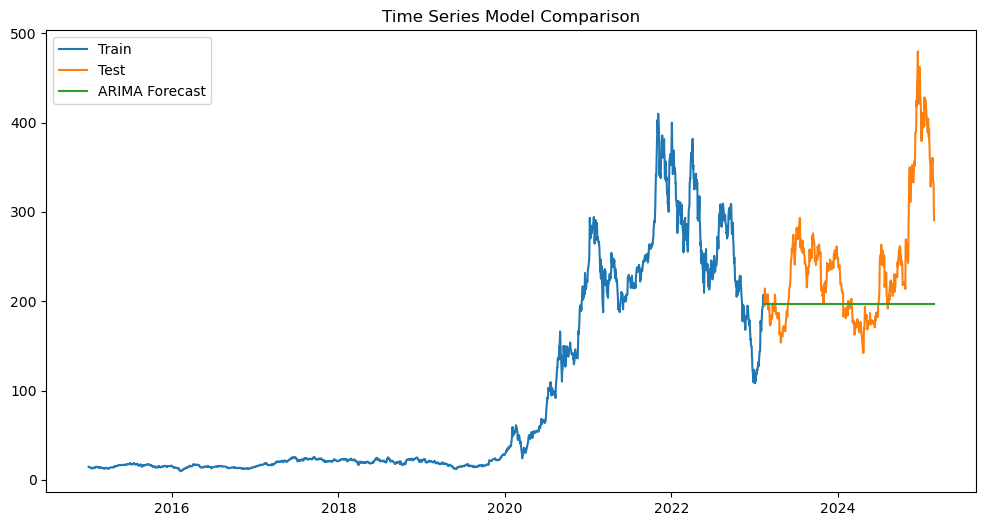

In [23]:

# Plotting results for visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot( train['Price'], label='Train')
plt.plot( test['Price'], label='Test')
plt.plot( test.index, forecast_arima, label='ARIMA Forecast')
# plt.plot(test['date'], es_forecast, label='Exponential Smoothing Forecast')
# plt.plot(test['date'], prophet_forecast['yhat'][-len(test):], label='Prophet Forecast')
plt.legend(loc='upper left')
plt.title('Time Series Model Comparison')
plt.show()


### Sarima

In [24]:
# Find optimal SARIMA parameters
sarima_model = auto_arima(train, start_p=1, start_q=1, max_p=3, max_q=3, start_P=1, seasonal=True, m=12, trace=True)
sarima_model.summary()


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=12782.563, Time=4.78 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=12788.100, Time=0.09 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=12787.931, Time=0.78 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=12788.316, Time=0.96 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=12786.629, Time=0.06 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=12789.313, Time=2.41 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=12788.963, Time=3.49 sec
 ARIMA(1,1,1)(2,0,1)[12] intercept   : AIC=12761.885, Time=8.90 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=12759.886, Time=4.49 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=12759.147, Time=2.68 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=12788.028, Time=1.04 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=12761.145, Time=5.24 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=12781.988, Time=2.24 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=12759.465, Time=2.33 sec
 ARIM

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 2042
Model:             SARIMAX(2, 1, 3)x(2, 0, [], 12)   Log Likelihood               -6357.802
Date:                             Tue, 04 Mar 2025   AIC                          12731.605
Time:                                     22:29:56   BIC                          12776.574
Sample:                                          0   HQIC                         12748.100
                                            - 2042                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1048      0.023    -47.415      0.000      -1.151      -1.059
ar.L2         -0.8375      0.026    -31.739      0.000      -0.889      -0.786
ma.L1          1.0885      0.025     42.882      0.000       1.039       1.138
ma.L2          0.7994      0.029     27.171      0.000       0.742       0.857
ma.L3         -0.0808      0.013     -6.315      0.000      -0.106      -0.056
ar.S.L12       0.0093      0.014      0.656      0.512      -0.018       0.037
ar.S.L24       0.1135      0.012      9.686      0.000       0.091       0.136
sigma2        29.7221      0.346     85.811      0.000      29.043      30.401
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):             16938.24
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):             545.19   Skew:                            -0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
print(sarima_model.order)
print(sarima_model.seasonal_order)

(2, 1, 3)
(2, 0, 0, 12)


In [26]:
p, d, q  = sarima_model.order
P, D, Q, s =  sarima_model.seasonal_order

sarima_model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_result = sarima_model.fit()

# Forecast and evaluate
forecast_sarima = sarima_result.forecast(steps=len(test))
mae_sarima = mean_absolute_error(test, forecast_sarima)
rmse_sarima = np.sqrt(mean_squared_error(test, forecast_sarima))
mape_sarima = np.mean(np.abs((test['Price'] - forecast_sarima) / test['Price'])) * 100


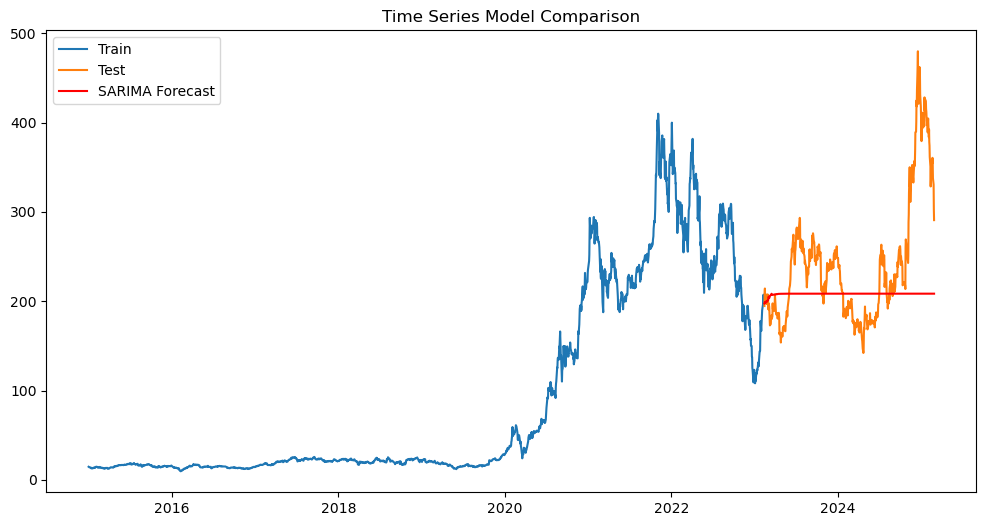

In [27]:

# Plotting results for visualization
plt.figure(figsize=(12, 6))
plt.plot( train['Price'], label='Train')
plt.plot( test['Price'], label='Test')
plt.plot( test.index, forecast_sarima, label='SARIMA Forecast', color='red')
# plt.plot(test['date'], es_forecast, label='Exponential Smoothing Forecast')
# plt.plot(test['date'], prophet_forecast['yhat'][-len(test):], label='Prophet Forecast')
plt.legend(loc='upper left')
plt.title('Time Series Model Comparison')
plt.show()


### LSTM

In [28]:
# Normalize data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Reshape into sequences
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Create train and test sequences
seq_length = 60
X_train, y_train = create_sequences(scaled_data[:train_size], seq_length)
X_test, y_test = create_sequences(scaled_data[train_size-seq_length:], seq_length)


In [29]:
X_test.shape

(511, 60, 1)

In [30]:
X_train.shape

(1982, 60, 1)

In [31]:
X_train.shape[1]

60

In [32]:
# Build LSTM model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

# Compile model
lstm_model.compile(optimizer="adam", loss="mean_squared_error")

# Train model
lstm_model.fit(X_train, y_train, epochs=10, batch_size=32)

# Forecast with LSTM model
predicted_prices = lstm_model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)
real_prices = scaler.inverse_transform(y_test)

# Evaluation metrics
mae_lstm = mean_absolute_error(real_prices, predicted_prices)
rmse_lstm = np.sqrt(mean_squared_error(real_prices, predicted_prices))
mape_lstm = np.mean(np.abs((real_prices - predicted_prices) / real_prices)) * 100


Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - loss: 0.0196
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 8.4258e-04
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 7.2588e-04
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 7.7043e-04
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 5.9675e-04
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 5.5794e-04
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 4.4084e-04
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 5.2124e-04
Epoch 9/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 4.9485e-04
Epoch 10/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 4.9298e-04
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


In [33]:
mape_lstm

4.456443734068932

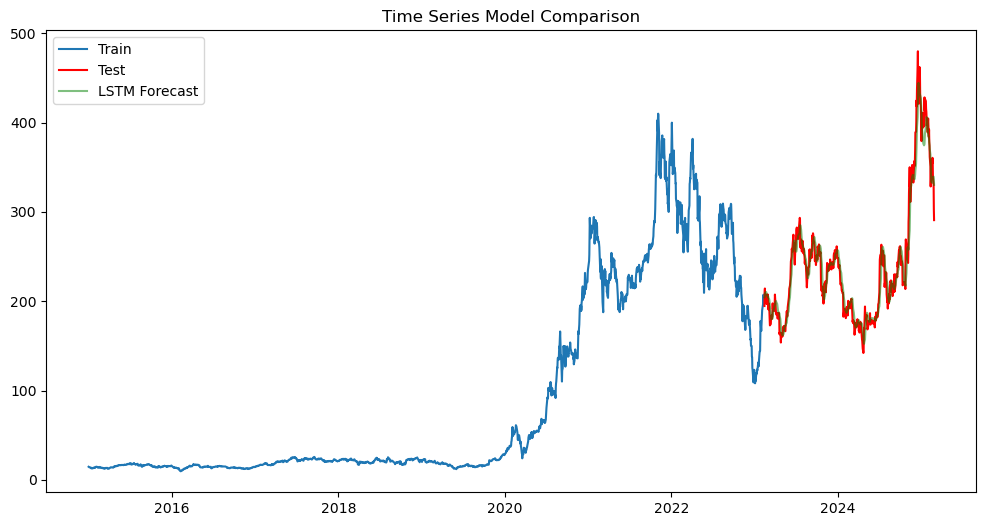

In [34]:

# Plotting results for visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot( train['Price'], label='Train')
plt.plot( test['Price'], label='Test', color='red')
plt.plot( test.index, predicted_prices, label='LSTM Forecast', color='green', alpha=0.5)
plt.legend(loc='upper left')
plt.title('Time Series Model Comparison')
plt.show()


##  Visualize Predictions

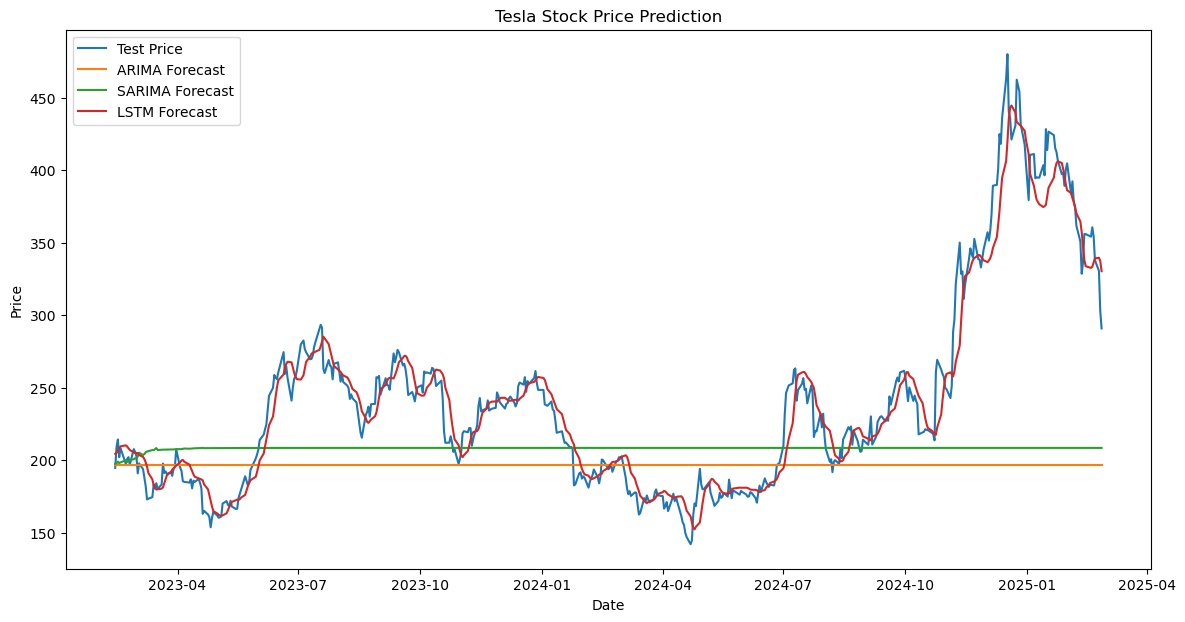

In [35]:
plt.figure(figsize=(14, 7))
plt.plot(df.index[train_size:], test['Price'], label="Test Price")
plt.plot(df.index[train_size:], forecast_arima, label="ARIMA Forecast")
plt.plot(df.index[train_size:], forecast_sarima, label="SARIMA Forecast")
plt.plot(df.index[train_size:], predicted_prices, label="LSTM Forecast")
plt.title("Tesla Stock Price Prediction")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


In [36]:
import joblib

# Assuming 'model' is your trained model
joblib.dump(lstm_model, '../models/best_model.pkl')

['../models/best_model.pkl']

In [37]:
import os

# Define the directory and file path
directory = '../data/'
csv_file_path = os.path.join(directory, 'my_data.csv')

# Create the directory if it doesn't exist
os.makedirs(directory, exist_ok=True)

# Save the DataFrame to the CSV file
df.to_csv(csv_file_path, index=False)

# Task-3

In [38]:
forecast_horizon = 730 


In [39]:
X_test[-1].shape

(60, 1)

In [40]:
last_sequence = X_test[-1]  # Start from the last observed sequence

In [41]:
last_sequences = last_sequence[np.newaxis, :, :]

In [42]:
print(last_sequences.shape)  # Should output (timesteps, features)

(1, 60, 1)


In [43]:
print(last_sequence[np.newaxis, :, :].shape)  # Should output (timesteps, features)

(1, 60, 1)


In [46]:
# Prepare LSTM forecast data


lstm_forecast = []
for _ in range(forecast_horizon):
    prediction = lstm_model.predict(last_sequences)
    lstm_forecast.append(prediction[0, 0])
    # Update the sequence to include the new prediction
    last_sequence = np.append(last_sequence[1:], prediction)[np.newaxis, :, np.newaxis]

# Rescale forecast back to original scale
lstm_forecast = scaler.inverse_transform(np.array(lstm_forecast).reshape(-1, 1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━

AttributeError: 'MinMaxScaler' object has no attribute 'min_'

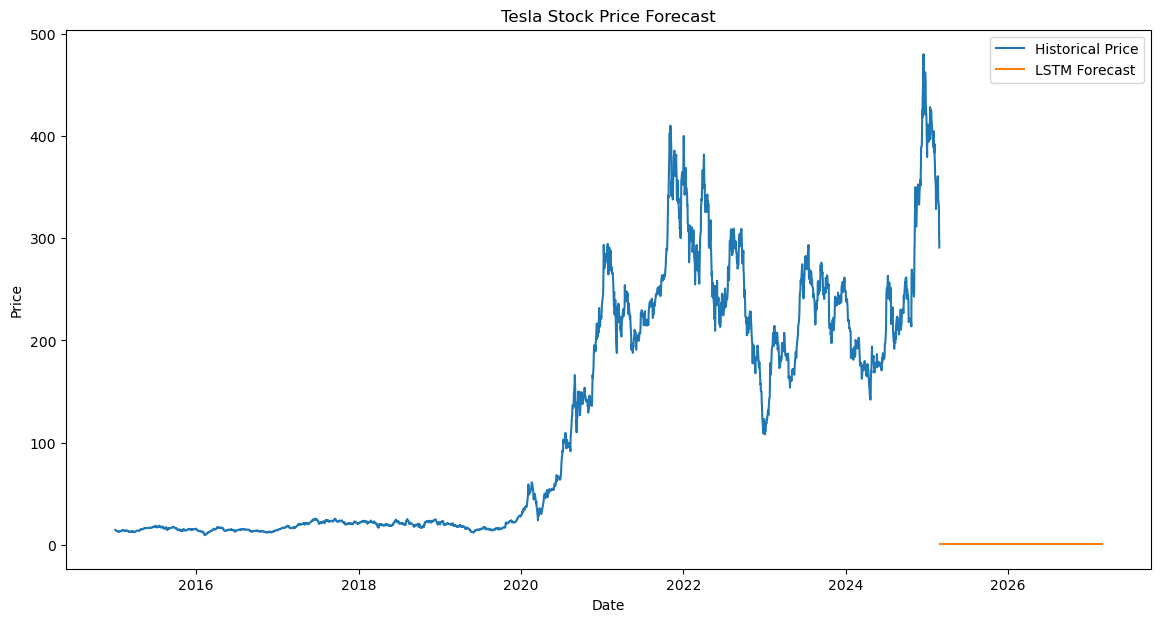

In [47]:
# Plot historical df and forecast
plt.figure(figsize=(14, 7))
plt.plot(df.index, df["Price"], label="Historical Price")

# Plot LSTM forecast
future_dates = pd.date_range(df.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon)
plt.plot(future_dates, lstm_forecast, label="LSTM Forecast")

plt.title("Tesla Stock Price Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


In [49]:
close_data.shape


(2553,)

In [50]:
X_test.shape

(511, 60, 1)

In [51]:
def predict(num_prediction, model):
    prediction_list = close_data[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    
def predict_dates(num_prediction):
    last_date = df.index.values[-1]
    prediction_dates = pd.date_range(last_date+1, periods=num_prediction+1).tolist()
    return prediction_dates



In [186]:
df.index

DatetimeIndex(['2015-01-02 00:00:00+00:00', '2015-01-05 00:00:00+00:00',
               '2015-01-06 00:00:00+00:00', '2015-01-07 00:00:00+00:00',
               '2015-01-08 00:00:00+00:00', '2015-01-09 00:00:00+00:00',
               '2015-01-12 00:00:00+00:00', '2015-01-13 00:00:00+00:00',
               '2015-01-14 00:00:00+00:00', '2015-01-15 00:00:00+00:00',
               ...
               '2024-10-17 00:00:00+00:00', '2024-10-18 00:00:00+00:00',
               '2024-10-21 00:00:00+00:00', '2024-10-22 00:00:00+00:00',
               '2024-10-23 00:00:00+00:00', '2024-10-24 00:00:00+00:00',
               '2024-10-25 00:00:00+00:00', '2024-10-28 00:00:00+00:00',
               '2024-10-29 00:00:00+00:00', '2024-10-30 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Date', length=2474, freq=None)